In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os,glob 
import re
plt.style.use('seaborn-whitegrid')

## Visual Inspection <a class="anchor" id="1"></a>

### Load / Clean data

 read excel file with results from visual inspection (vi)   
 these are ART's scored as either parallel (homoplasies) , sequential (stepwise) or both   
 all ART's not on this list are conserved states or other (a - d Figure 1)

In [2]:
results_vi = pd.concat(pd.read_excel('validation_data.xlsx', sheet_name=None), ignore_index=True, sort=False)
results_vi.dropna(axis='columns', inplace=True)
results_vi.head()

,Position,ORF,Parallel,Sequential
0,88,Orf1a,0,1
1,158,Orf1a,1,0
2,339,Orf1a,1,1
3,357,Orf1a,1,0
4,364,Orf1a,1,1


some of the sites are duplicated as they belong to both Orf1a and Orf1b.   
we removed duplicates as not to skew results

In [3]:
results_vi[results_vi['Position']==88]

,Position,ORF,Parallel,Sequential
0,88,Orf1a,0,1


In [4]:
art_ids = results_vi['Position']
results_vi[art_ids.isin(art_ids[art_ids.duplicated()])]
#remove duplicates
results_vi.drop_duplicates(subset=['Position'],inplace=True)
#check no duplicates again
art_ids = results_vi['Position']
results_vi[art_ids.isin(art_ids[art_ids.duplicated()])]

,Position,ORF,Parallel,Sequential


the algorithm classifies evolutionary patterns found in each ART into   
conserved, inter-homoplasy, intra-homoplasy, stepwise or other.

Coding for the classification:

0 : (b) apomorphy, (c) synapomorphy, (d) autapomorphy, other  
1 : (a) conserved  
2 : (e) homoplasy (inter and/or intra) / parallel evolution   
3 : (f) stepwise / sequential evolution  
4 : (e) & (f)  

In [5]:
# mapping of evolutionary patterns

def conditions_vi(df):
    if (df['Parallel']==1) & (df['Sequential']==0):
        return 2
    elif (df['Parallel']==0) & (df['Sequential']==1):
        return 3
    else:
        return 4

In [6]:
# apply mapping to results and into new column
results_vi['y_vi'] = results_vi.apply(conditions_vi, axis=1)
results_vi.head()

,Position,ORF,Parallel,Sequential,y_vi
0,88,Orf1a,0,1,3
1,158,Orf1a,1,0,2
2,339,Orf1a,1,1,4
3,357,Orf1a,1,0,2
4,364,Orf1a,1,1,4


In [7]:
# we can check results at specific position
results_vi[results_vi['Position']==803]

,Position,ORF,Parallel,Sequential,y_vi


### Distribution

In [8]:
#calculate counts
homoplasy = sum(results_vi['Parallel'])
stepwise = sum(results_vi['Sequential'])
both = (sum(results_vi['Parallel']) + sum(results_vi['Sequential'])) - results_vi['Position'].count()
total = results_vi['Position'].count()

print('Count:')
print('homoplasy: ', homoplasy)
print('stepwise: ', stepwise)
print('both: ', both)
print('total: ', total)

Count:
homoplasy:  150
stepwise:  113
both:  45
total:  218


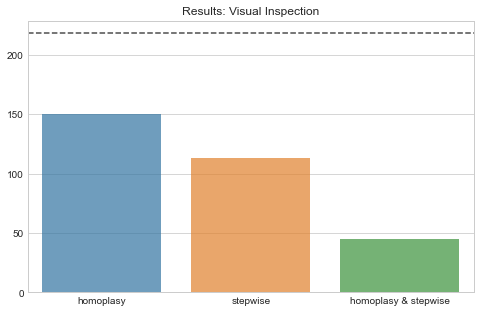

In [9]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['homoplasy', 'stepwise', 'homoplasy & stepwise'],y=[homoplasy, stepwise, both], alpha=0.7)
ax.axhline(total, ls='--', color='black',alpha=0.7)
plt.savefig('figures/visual_inspection.png')
plt.title('Results: Visual Inspection');

## Algorithmic Results   
### Load / Clean data

In [10]:
# read results
path = 'results/' 
all_files = glob.glob(path + "/all.csv")

l = []

for filename in all_files:
    df = pd.read_csv(filename, header=None, index_col=None)
    l.append(df)

results_alg = pd.concat(l, axis=0, ignore_index=True)

In [11]:
results_alg.head()

,0,1,2,3,4,5
0,RASML/HumanBeta_Site4062.tree,0.0,1.0,0.0,0.0,0.0
1,RASML/HumanBeta_Site1572.tree,0.0,0.0,0.0,0.0,0.0
2,RASML/HumanBeta_Site2586.tree,0.0,0.0,0.0,0.0,0.0
3,RASML/HumanBeta_Site3233.tree,0.0,0.0,0.0,0.0,0.0
4,RASML/HumanBeta_Site6284.tree,0.0,0.0,0.0,0.0,0.0


In [12]:
len(results_alg)

6681

In [13]:
# format data
results_alg['Position'] = pd.to_numeric(results_alg[0].str.extract(r"(\d+)(\.)", )[0])
results_alg.sort_values(by = ['Position'],inplace=True)
results_alg.drop([0], axis=1,inplace=True)
results_alg.columns=['Low Freq Var','Conserved','Inter', 'Intra', 'Stepwise','Position']
cols = results_alg.columns.tolist()
cols = cols[-1:] + cols[:-1]
results_alg = results_alg[cols]
homoplasy = (results_alg['Inter']==1) | (results_alg['Inter']==1)
results_alg['Homoplasy'] = homoplasy

In [14]:
# function for adding new column with coded results
def conditions_alg(df):
    if df['Conserved']==1:
        return 1
    elif (df['Inter']==1 or df['Intra']==1):
        if df['Stepwise']==0:
            return 2
        else:
            return 4
    elif (df['Inter']==0 and df['Intra']==0 and df['Stepwise']==1):
        return 3
    else:
        return 0

In [15]:
results_alg['y_alg'] = results_alg.apply(conditions_alg, axis=1)
results_alg.head()

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg
5061,1,0.0,1.0,1.0,0.0,1.0,True,1
2207,2,0.0,0.0,0.0,0.0,0.0,False,0
2555,3,0.0,0.0,0.0,0.0,0.0,False,0
2193,4,0.0,0.0,0.0,0.0,0.0,False,0
5986,14,0.0,0.0,0.0,0.0,0.0,False,0


### Distribution

In [16]:
lfv = results_alg[results_alg['Low Freq Var'] == 1]

In [17]:
results_vi[results_vi['Position'] == 1449]

,Position,ORF,Parallel,Sequential,y_vi


In [18]:
results_alg[results_alg['Position'] == 1449]

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg
2887,1449,1.0,0.0,0.0,0.0,0.0,False,0


In [19]:
#low frequency variants
total = len(results_alg['Low Freq Var'])
low_freq_var = sum(results_alg['Low Freq Var'])
percentage = (low_freq_var *100) / total 
print('low frequency variants: ', round(low_freq_var))
print('total: ', total)

low frequency variants:  1173
total:  6681


In [20]:
total = len(results_alg['Conserved'])
conserved = sum(results_alg['Conserved'])
percentage = (conserved *100) / total 
print('conserved sites: ', round(conserved))

variable = sum(results_alg['y_alg']!=1)
percentage = (variable *100) / total 
print('variable sites: ', variable)

print('total: ', total)

conserved sites:  1443
variable sites:  5238
total:  6681


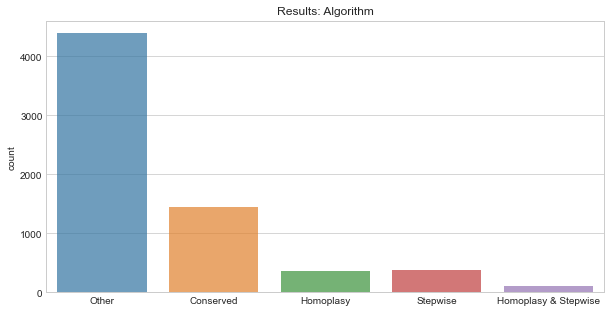

In [21]:
total = results_alg['y_alg'].count()
f, ax = plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-whitegrid')
f = sns.countplot(x='y_alg' ,data=results_alg, alpha=0.7)
plt.xticks(np.arange(5),('Other', 'Conserved', 'Homoplasy','Stepwise', 'Homoplasy & Stepwise'))
plt.title("Results: Algorithm")
plt.xlabel('')
plt.savefig('figures/algorithm_distribution.png')
plt.show(f)

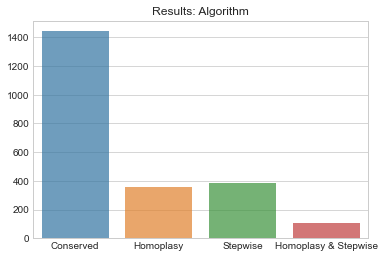

In [22]:
conserved = sum(results_alg['y_alg']==1)
homoplasy = sum(results_alg['y_alg']==2)
stepwise = sum(results_alg['y_alg']==3)
both = sum(results_alg['y_alg']==4)

f, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=['Conserved', 'Homoplasy', 'Stepwise', 'Homoplasy & Stepwise'],y=[conserved, homoplasy, stepwise, both], alpha=0.7)
plt.xlabel('')
plt.title('Results: Algorithm')
plt.savefig('figures/conserved_vs_variable.png')


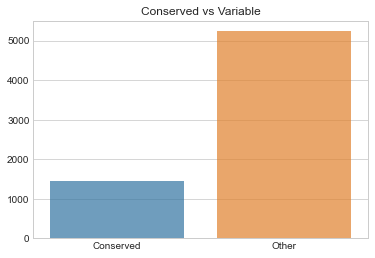

In [23]:
variable = sum(results_alg['y_alg']!=1)
conserved = sum(results_alg['y_alg']==1)

f, ax = plt.subplots(figsize=(6,4))
ax = sns.barplot(x=['Conserved', 'Other'],y=[conserved, variable], alpha=0.7)
plt.title('Conserved vs Variable')
plt.savefig('figures/conserved_vs_other.png')

## Confusion Matrix

In [24]:
### merge visual inspection and algorithmic results
df = results_alg.merge(results_vi, how='outer',on='Position')
df = df.where(pd.notnull(df), 0)

### merge inter and intra homoplasy
df['Homoplasy'] = (df['Inter']==1) | (df['Intra']==1)
df[(df['y_alg']>1) & (df['y_vi']==0)].head()

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg,ORF,Parallel,Sequential,y_vi
55,76,1.0,0.0,1.0,0.0,0.0,True,2,0,0.0,0.0,0.0
102,171,0.0,0.0,1.0,0.0,0.0,True,2,0,0.0,0.0,0.0
177,262,0.0,0.0,1.0,0.0,0.0,True,2,0,0.0,0.0,0.0
288,409,0.0,0.0,1.0,0.0,0.0,True,2,0,0.0,0.0,0.0
379,544,0.0,0.0,0.0,0.0,1.0,False,3,0,0.0,0.0,0.0


In [25]:
df[(df['Inter']==1) & (df['Parallel']==1)].head()

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg,ORF,Parallel,Sequential,y_vi
78,143,0.0,0.0,1.0,0.0,0.0,True,2,1,1.0,0.0,2.0
84,149,0.0,0.0,1.0,0.0,0.0,True,2,1,1.0,0.0,2.0
121,205,0.0,0.0,1.0,0.0,1.0,True,4,Ancestor?,1.0,1.0,4.0
122,206,0.0,0.0,1.0,0.0,1.0,True,4,1,1.0,1.0,4.0
127,211,0.0,0.0,1.0,0.0,0.0,True,2,1,1.0,0.0,2.0


In [26]:
#map
df['y_vi'] = df['y_vi'].map({0: 0, 2: 1, 3:1, 3:1, 4:1})
df['y_alg'] = df['y_alg'].map({0: 0, 1:0, 2: 1, 3: 1, 4: 1})

In [58]:
#counts
confusion_matrix = pd.crosstab(df['y_vi'], df['y_alg'], rownames=['Visual Inspection'], colnames=['Algorithm'])#, normalize='index')
print(confusion_matrix)

Algorithm             0    1
Visual Inspection           
0                  5834  629
1                     0  218


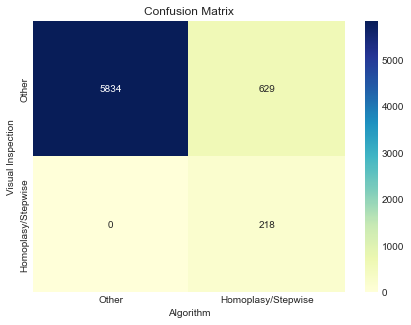

In [60]:
#visualisation
fig, ax = plt.subplots(figsize=(7,5))
x_axis_labels = ['Other', 'Homoplasy/Stepwise'] # labels for x-axis
y_axis_labels = ['Other', 'Homoplasy/Stepwise'] # labels for y-axis
sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#adjust y ticks
plt.yticks(np.arange(2)+0.5,('Other', 'Homoplasy/Stepwise'), va="center")
plt.title('Confusion Matrix')
plt.savefig('figures/confusion_matrix.png')
plt.savefig('figures/confusion_matrix.jpg')
plt.savefig('figures/confusion_matrix.tiff')
plt.show()

In [29]:
# False Negatives
fn = df[(df['y_vi']==1) & (df['y_alg']==0)]
print(list(fn['Position']))

[]


In [30]:
len(fn)

0

In [31]:
df[df['Position']==2193]

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg,ORF,Parallel,Sequential,y_vi
1650,2193,1.0,0.0,0.0,0.0,0.0,False,0,0,0.0,0.0,0


In [44]:
# False Positives
fp = df[(df['y_vi']==0) & (df['y_alg']==1) & (df['Stepwise']==1)]
print(list(fp['Position']))

[544, 928, 931, 933, 936, 945, 973, 983, 985, 999, 1001, 1147, 1154, 1172, 1174, 1183, 1190, 1202, 1337, 1374, 1384, 1403, 1406, 1422, 1513, 1516, 1544, 1674, 1700, 1769, 1852, 1951, 1953, 1968, 1976, 2026, 2029, 2125, 2132, 2196, 2202, 2219, 2255, 2276, 2281, 2299, 2307, 2342, 2362, 2414, 2415, 2441, 2485, 2510, 2547, 2569, 2571, 2648, 2653, 2674, 2795, 2910, 2986, 2997, 3001, 3049, 3058, 3140, 3192, 3193, 3243, 3317, 3318, 3326, 3338, 3407, 3410, 3411, 3489, 3490, 3512, 3572, 3577, 3638, 3646, 3666, 3804, 3809, 3857, 3866, 3892, 3897, 3922, 4016, 4018, 4019, 4022, 4101, 4121, 4167, 4174, 4184, 4190, 4220, 4267, 4281, 4350, 4372, 4419, 4460, 4518, 4523, 4559, 4566, 4609, 4736, 4860, 4920, 4970, 4993, 5011, 5025, 5079, 5108, 5183, 5247, 5273, 5279, 5301, 5314, 5333, 5339, 5395, 5456, 5485, 5486, 5500, 5501, 5528, 5559, 5585, 5617, 5624, 5625, 5631, 5665, 5668, 5673, 5702, 5729, 5751, 5762, 5765, 5770, 5816, 5822, 5877, 5884, 5885, 5897, 5909, 5923, 5930, 5944, 5955, 5960, 6014, 6025, 6

In [45]:
len(fp)

371

In [46]:
# merge only with visual inspection sites
df2 = results_alg.merge(results_vi, how='inner',on='Position')

In [47]:
#counts
confusion_matrix = pd.crosstab(df2['y_vi'], df2['y_alg'], rownames=['Visual Inspection'], colnames=['Algorithm'])#, normalize='index')
print (confusion_matrix)

Algorithm           2   3   4
Visual Inspection            
2                  81   4  20
3                   2  48  18
4                  15   5  25


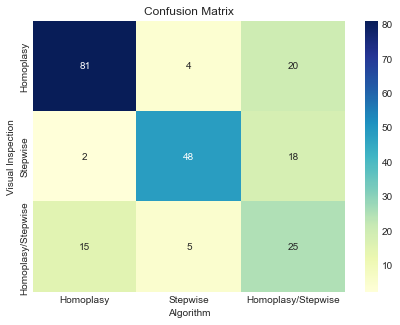

In [48]:
fig, ax = plt.subplots(figsize=(7,5))
x_axis_labels = ['Homoplasy', 'Stepwise', 'Homoplasy/Stepwise'] # labels for x-axis
y_axis_labels = ['Homoplasy', 'Stepwise', 'Homoplasy/Stepwise'] # labels for y-axis
sns.heatmap(confusion_matrix[[2,3,4]], annot=True,cmap="YlGnBu", fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#adjust y ticks
plt.yticks(np.arange(3)+0.5,('Homoplasy', 'Stepwise', 'Homoplasy/Stepwise'), va="center")
plt.title('Confusion Matrix')
plt.savefig('figures/confusion_matrix2.png')
plt.show()

In [49]:
#homoplasy
#counts
confusion_matrix3 = pd.crosstab(df2['Parallel'], df2['Homoplasy'], rownames=['Visual Inspection'], colnames=['Algorithm'])#, normalize='index')
print (confusion_matrix3)

Algorithm          False  True 
Visual Inspection              
0                     49     19
1                     12    138


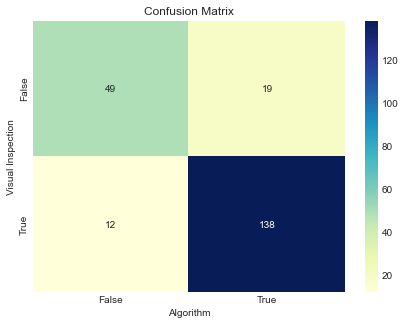

In [56]:
#visualisation
fig, ax = plt.subplots(figsize=(7,5))
x_axis_labels = ['False', 'True'] # labels for x-axis
y_axis_labels = ['False', 'True'] # labels for y-axis
sns.heatmap(confusion_matrix3, annot=True,cmap="YlGnBu", fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#adjust y ticks
plt.yticks(np.arange(2)+0.5,('False', 'True'), va="center")
plt.title('Confusion Matrix')
plt.savefig('figures/confusion_matrix.png')
plt.show()

In [51]:
#stepwise
confusion_matrix4 = pd.crosstab(df2['Sequential'], df2['Stepwise'], rownames=['Visual Inspection'], colnames=['Algorithm'])#, normalize='index')
print (confusion_matrix4)

Algorithm          0.0  1.0
Visual Inspection          
0                   81   24
1                   17   96


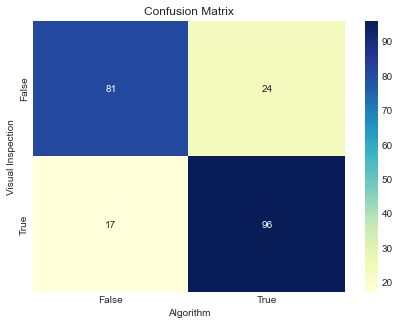

In [52]:
#visualisation
fig, ax = plt.subplots(figsize=(7,5))
x_axis_labels = ['False', 'True'] # labels for x-axis
y_axis_labels = ['False', 'True'] # labels for y-axis
sns.heatmap(confusion_matrix4, annot=True,cmap="YlGnBu", fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#adjust y ticks
plt.yticks(np.arange(2)+0.5,('False', 'True'), va="center")
plt.title('Confusion Matrix')
plt.savefig('figures/confusion_matrix.png')
plt.show()

In [53]:
df2.head()

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg,ORF,Parallel,Sequential,y_vi
0,38,1.0,0.0,0.0,0.0,1.0,False,3,"Ancestor?, X, LFV",0,1,3
1,39,1.0,0.0,0.0,0.0,1.0,False,3,Ancestor? X,0,1,3
2,84,0.0,0.0,0.0,0.0,1.0,False,3,"Ancestor? X, LFV",0,1,3
3,85,0.0,0.0,0.0,0.0,1.0,False,3,"Ancestor? X, LFV",0,1,3
4,88,1.0,0.0,1.0,0.0,1.0,True,4,Orf1a,0,1,3


In [55]:
df2[(df2['Inter']==1) & (df2['Parallel']==1)]

,Position,Low Freq Var,Conserved,Inter,Intra,Stepwise,Homoplasy,y_alg,ORF,Parallel,Sequential,y_vi
5,143,0.0,0.0,1.0,0.0,0.0,True,2,1,1,0,2
6,149,0.0,0.0,1.0,0.0,0.0,True,2,1,1,0,2
10,205,0.0,0.0,1.0,0.0,1.0,True,4,Ancestor?,1,1,4
11,206,0.0,0.0,1.0,0.0,1.0,True,4,1,1,1,4
13,211,0.0,0.0,1.0,0.0,0.0,True,2,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
212,7673,0.0,0.0,1.0,0.0,1.0,True,4,Spike,1,1,4
213,7724,0.0,0.0,1.0,0.0,1.0,True,4,Spike,1,0,2
215,7769,1.0,0.0,1.0,0.0,1.0,True,4,Spike,1,0,2
216,7777,0.0,0.0,1.0,0.0,1.0,True,4,Spike,1,0,2
